In [1]:
"""
Author: Alan, Chen
Email: alanchen0922@gmail.com

paper: https://arxiv.org/abs/1611.08024
"""

'\nAuthor: Alan, Chen\nEmail: alanchen0922@gmail.com\n\npaper: https://arxiv.org/abs/1611.08024\n'

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Function
from torch.nn.modules.module import Module
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import numpy as np

from torchsummary import summary


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [3]:
def read_bci_data():
    S4b_train = np.load('S4b_train.npz')
    X11b_train = np.load('X11b_train.npz')
    S4b_test = np.load('S4b_test.npz')
    X11b_test = np.load('X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)

    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

    print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

    return train_data, train_label, test_data, test_label

In [4]:
class DepthwiseConv2d(torch.nn.Conv2d):
    def __init__(self,
                 in_channels,
                 depth_multiplier=1,
                 kernel_size=3,
                 stride=1,
                 padding=0,
                 dilation=1,
                 bias=True,
                 padding_mode='zeros'
                 ):
        out_channels = in_channels * depth_multiplier
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=in_channels,
            bias=bias,
            padding_mode=padding_mode
        )

In [5]:
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, groups=in_channels, bias=bias, padding=0)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
    
    def forward(self,x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [107]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.C = 2
        self.T = 750
        self.F1 = 16
        self.D = 2
        self.F2 = 32
        self.kernel_length = 64
        self.dropoutRate = 0.2
        self.classes = 2
        
        # block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.F1, kernel_size=(1, 51), padding=(0, 25), stride=(1, 1), bias=False)
#         self.zeropad1 = nn.ZeroPad2d((31, 32, 0, 0))
        self.batchnorm1 = nn.BatchNorm2d(self.F1)
        self.depthwise1 = DepthwiseConv2d(self.F1, kernel_size=(self.C, 1), depth_multiplier=self.D, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(self.F1*self.D)
        self.averagePooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(p=self.dropoutRate)
        
        # block 2
        self.separableconv1 = SeparableConv2d(self.F1*self.D, self.F2, kernel_size=(1, 16), bias=False, padding=0)
        self.zeropad2 = nn.ZeroPad2d((8, 7, 0, 0))
        self.batchnorm3 = nn.BatchNorm2d(self.F2)
        self.averagePooling2 = nn.AvgPool2d(kernel_size=(1,8))
        self.dropout2 = nn.Dropout(p=self.dropoutRate)
        self.flatten1 = nn.Flatten()
        
        self.dense1 = nn.Linear(self.F2*(self.T//32), self.classes)
        
        # activation function
        self.ReLU = nn.ReLU()
        self.leakyReLU = nn.LeakyReLU()
        
    def forward(self, x):
        
        ## block 1
#         print("input",x.shape)
        x = self.conv1(x)
#         print("conv1", x.shape)
#         x = self.zeropad1(x)
#         print("zeropad", x.shape)
        x = self.batchnorm1(x)
#         print("batchnorm", x.shape)
        x = self.depthwise1(x)
#         print("depthwise", x.shape)
        x = self.batchnorm2(x)
#         print("batchnorm",x.shape)
        
#         x = self.leakyReLU(x)
        x = self.ReLU(x)
#         x = F.elu(x) #activation


        x = self.averagePooling1(x)
#         print("averagePooling1", x.shape)
        x = self.dropout1(x)
#         print("dropout1", x.shape)
        
        ## block 2
        x = self.separableconv1(x)
#         print("separableconv", x.shape)
        x = self.zeropad2(x)
#         print("zeropad", x.shape)
        x = self.batchnorm3(x)
#         print("batchnorm", x.shape)

#         x = self.leakyReLU(x)
        x = self.ReLU(x)
#         x = F.elu(x) #activation

        x = self.averagePooling2(x)
#         print("averagePool", x.shape)
        x = self.dropout2(x)
        x = self.flatten1(x)
#         print("flatten", x.shape)
        x = self.dense1(x)
#         print("dense", x.shape)
#         x = F.softmax(x, dim=1)
        
        return x
    
model = EEGNet().to(device)
# print(model)
summary(model, (1, 2, 750))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 2, 750]             816
       BatchNorm2d-2           [-1, 16, 2, 750]              32
   DepthwiseConv2d-3           [-1, 32, 1, 750]              64
       BatchNorm2d-4           [-1, 32, 1, 750]              64
              ReLU-5           [-1, 32, 1, 750]               0
         AvgPool2d-6           [-1, 32, 1, 187]               0
           Dropout-7           [-1, 32, 1, 187]               0
            Conv2d-8           [-1, 32, 1, 172]             512
            Conv2d-9           [-1, 32, 1, 172]           1,024
  SeparableConv2d-10           [-1, 32, 1, 172]               0
        ZeroPad2d-11           [-1, 32, 1, 187]               0
      BatchNorm2d-12           [-1, 32, 1, 187]              64
             ReLU-13           [-1, 32, 1, 187]               0
        AvgPool2d-14            [-1, 32

In [108]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avg_loss, avg_acc = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
        avg_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
    avg_loss /= len(dataloader)
    avg_acc /= len(dataloader.dataset)
    return 100*avg_acc, avg_loss


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return 100*correct, test_loss

In [109]:
from sklearn import preprocessing

x_train, y_train, x_test, y_test = read_bci_data()

## Data Preprocessing

# x_train = np.delete(x_train, [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 14, 15, 16, 17, 18, 32, 33, 36, 44, 45, 46, 53, 54, 57, 58, 59, 60, 61, 62, 63, 64], axis=0)
# y_train = np.delete(y_train, [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 14, 15, 16, 17, 18, 32, 33, 36, 44, 45, 46, 53, 54, 57, 58, 59, 60, 61, 62, 63, 64], axis=0)

# x_train = x_train.reshape(-1, 1*2*750)
# x_test = x_test.reshape(-1, 1*2*750)
# scaler = preprocessing.StandardScaler().fit(x_train)
# x_train = scaler.transform(x_train)
# x_test = scaler.transform(x_test)
# x_train = x_train.reshape(-1, 1, 2, 750)
# x_test = x_test.reshape(-1, 1, 2, 750)


x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).type(torch.LongTensor).to(device)

x_test = torch.from_numpy(x_test).float().to(device)
y_test = torch.from_numpy(y_test).type(torch.LongTensor).to(device) # data type is long

train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

batch_size = 64
train_loader = DataLoader(
    dataset=train,
    batch_size=batch_size,
#     shuffle=True,
)

test_loader = DataLoader(
    dataset=test,
    batch_size=batch_size,
#     shuffle=True,
)

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


In [110]:
epochs = 500
learning_rate = 1e-2
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_acc = []
train_loss = []
test_acc = []
test_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tr_acc, tr_loss = train_loop(train_loader, model, loss_fn, optimizer)
    te_acc, te_loss = test_loop(test_loader, model, loss_fn)
    train_acc.append(tr_acc)
    train_loss.append(tr_loss)
    test_acc.append(te_acc)
    test_loss.append(te_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.731579  [    0/ 1080]
loss: 0.934778  [  640/ 1080]
Test Error: 
 Accuracy: 69.6%, Avg loss: 0.628758 

Epoch 2
-------------------------------
loss: 1.116539  [    0/ 1080]
loss: 0.657668  [  640/ 1080]
Test Error: 
 Accuracy: 70.8%, Avg loss: 0.554461 

Epoch 3
-------------------------------
loss: 0.931053  [    0/ 1080]
loss: 0.651268  [  640/ 1080]
Test Error: 
 Accuracy: 73.0%, Avg loss: 0.542191 

Epoch 4
-------------------------------
loss: 0.850720  [    0/ 1080]
loss: 0.547738  [  640/ 1080]
Test Error: 
 Accuracy: 72.3%, Avg loss: 0.545183 

Epoch 5
-------------------------------
loss: 0.870120  [    0/ 1080]
loss: 0.547622  [  640/ 1080]
Test Error: 
 Accuracy: 73.7%, Avg loss: 0.525763 

Epoch 6
-------------------------------
loss: 0.841812  [    0/ 1080]
loss: 0.515345  [  640/ 1080]
Test Error: 
 Accuracy: 73.0%, Avg loss: 0.549231 

Epoch 7
-------------------------------
loss: 0.921506  [    0/ 1080]
loss: 0.566113  [ 

Test Error: 
 Accuracy: 76.6%, Avg loss: 0.643166 

Epoch 55
-------------------------------
loss: 0.478340  [    0/ 1080]
loss: 0.163867  [  640/ 1080]
Test Error: 
 Accuracy: 76.3%, Avg loss: 0.674343 

Epoch 56
-------------------------------
loss: 0.674504  [    0/ 1080]
loss: 0.172637  [  640/ 1080]
Test Error: 
 Accuracy: 75.8%, Avg loss: 0.679472 

Epoch 57
-------------------------------
loss: 0.495648  [    0/ 1080]
loss: 0.130479  [  640/ 1080]
Test Error: 
 Accuracy: 76.0%, Avg loss: 0.676227 

Epoch 58
-------------------------------
loss: 0.496554  [    0/ 1080]
loss: 0.156538  [  640/ 1080]
Test Error: 
 Accuracy: 76.3%, Avg loss: 0.649885 

Epoch 59
-------------------------------
loss: 0.437506  [    0/ 1080]
loss: 0.137144  [  640/ 1080]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.662897 

Epoch 60
-------------------------------
loss: 0.482452  [    0/ 1080]
loss: 0.166768  [  640/ 1080]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.661932 

Epoch 61
---------------------

Test Error: 
 Accuracy: 77.1%, Avg loss: 0.831011 

Epoch 109
-------------------------------
loss: 0.317752  [    0/ 1080]
loss: 0.123079  [  640/ 1080]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.739416 

Epoch 110
-------------------------------
loss: 0.219452  [    0/ 1080]
loss: 0.175559  [  640/ 1080]
Test Error: 
 Accuracy: 79.1%, Avg loss: 0.769486 

Epoch 111
-------------------------------
loss: 0.171488  [    0/ 1080]
loss: 0.072330  [  640/ 1080]
Test Error: 
 Accuracy: 75.4%, Avg loss: 0.843117 

Epoch 112
-------------------------------
loss: 0.251701  [    0/ 1080]
loss: 0.082675  [  640/ 1080]
Test Error: 
 Accuracy: 77.3%, Avg loss: 0.854470 

Epoch 113
-------------------------------
loss: 0.325188  [    0/ 1080]
loss: 0.234145  [  640/ 1080]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.803983 

Epoch 114
-------------------------------
loss: 0.288026  [    0/ 1080]
loss: 0.154327  [  640/ 1080]
Test Error: 
 Accuracy: 76.1%, Avg loss: 0.799790 

Epoch 115
--------------

Test Error: 
 Accuracy: 77.3%, Avg loss: 0.962739 

Epoch 163
-------------------------------
loss: 0.292057  [    0/ 1080]
loss: 0.124765  [  640/ 1080]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.973511 

Epoch 164
-------------------------------
loss: 0.231457  [    0/ 1080]
loss: 0.066893  [  640/ 1080]
Test Error: 
 Accuracy: 76.2%, Avg loss: 0.927433 

Epoch 165
-------------------------------
loss: 0.319852  [    0/ 1080]
loss: 0.067774  [  640/ 1080]
Test Error: 
 Accuracy: 77.2%, Avg loss: 0.948775 

Epoch 166
-------------------------------
loss: 0.300373  [    0/ 1080]
loss: 0.113186  [  640/ 1080]
Test Error: 
 Accuracy: 76.7%, Avg loss: 1.009600 

Epoch 167
-------------------------------
loss: 0.224678  [    0/ 1080]
loss: 0.113840  [  640/ 1080]
Test Error: 
 Accuracy: 76.6%, Avg loss: 0.930104 

Epoch 168
-------------------------------
loss: 0.197226  [    0/ 1080]
loss: 0.049028  [  640/ 1080]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.859487 

Epoch 169
--------------

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.872366 

Epoch 217
-------------------------------
loss: 0.215372  [    0/ 1080]
loss: 0.103152  [  640/ 1080]
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.935177 

Epoch 218
-------------------------------
loss: 0.142721  [    0/ 1080]
loss: 0.087775  [  640/ 1080]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.893145 

Epoch 219
-------------------------------
loss: 0.144691  [    0/ 1080]
loss: 0.108573  [  640/ 1080]
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.941279 

Epoch 220
-------------------------------
loss: 0.119122  [    0/ 1080]
loss: 0.062740  [  640/ 1080]
Test Error: 
 Accuracy: 79.8%, Avg loss: 0.974979 

Epoch 221
-------------------------------
loss: 0.121846  [    0/ 1080]
loss: 0.082734  [  640/ 1080]
Test Error: 
 Accuracy: 79.0%, Avg loss: 0.983166 

Epoch 222
-------------------------------
loss: 0.138393  [    0/ 1080]
loss: 0.026988  [  640/ 1080]
Test Error: 
 Accuracy: 78.4%, Avg loss: 1.070069 

Epoch 223
--------------

Test Error: 
 Accuracy: 79.0%, Avg loss: 0.922318 

Epoch 271
-------------------------------
loss: 0.131072  [    0/ 1080]
loss: 0.128105  [  640/ 1080]
Test Error: 
 Accuracy: 79.0%, Avg loss: 0.981576 

Epoch 272
-------------------------------
loss: 0.101723  [    0/ 1080]
loss: 0.021887  [  640/ 1080]
Test Error: 
 Accuracy: 78.8%, Avg loss: 1.085929 

Epoch 273
-------------------------------
loss: 0.094926  [    0/ 1080]
loss: 0.118508  [  640/ 1080]
Test Error: 
 Accuracy: 77.1%, Avg loss: 1.079794 

Epoch 274
-------------------------------
loss: 0.209583  [    0/ 1080]
loss: 0.057975  [  640/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 1.074043 

Epoch 275
-------------------------------
loss: 0.202676  [    0/ 1080]
loss: 0.165032  [  640/ 1080]
Test Error: 
 Accuracy: 78.2%, Avg loss: 1.153968 

Epoch 276
-------------------------------
loss: 0.263671  [    0/ 1080]
loss: 0.208407  [  640/ 1080]
Test Error: 
 Accuracy: 76.7%, Avg loss: 1.055861 

Epoch 277
--------------

Test Error: 
 Accuracy: 77.7%, Avg loss: 1.123146 

Epoch 325
-------------------------------
loss: 0.204830  [    0/ 1080]
loss: 0.068556  [  640/ 1080]
Test Error: 
 Accuracy: 79.2%, Avg loss: 1.143076 

Epoch 326
-------------------------------
loss: 0.141752  [    0/ 1080]
loss: 0.151401  [  640/ 1080]
Test Error: 
 Accuracy: 77.1%, Avg loss: 1.102338 

Epoch 327
-------------------------------
loss: 0.178094  [    0/ 1080]
loss: 0.068634  [  640/ 1080]
Test Error: 
 Accuracy: 79.5%, Avg loss: 1.115766 

Epoch 328
-------------------------------
loss: 0.184541  [    0/ 1080]
loss: 0.009968  [  640/ 1080]
Test Error: 
 Accuracy: 76.9%, Avg loss: 1.114463 

Epoch 329
-------------------------------
loss: 0.067880  [    0/ 1080]
loss: 0.124597  [  640/ 1080]
Test Error: 
 Accuracy: 75.4%, Avg loss: 1.195539 

Epoch 330
-------------------------------
loss: 0.218470  [    0/ 1080]
loss: 0.157330  [  640/ 1080]
Test Error: 
 Accuracy: 76.9%, Avg loss: 1.245345 

Epoch 331
--------------

Test Error: 
 Accuracy: 77.7%, Avg loss: 1.179162 

Epoch 379
-------------------------------
loss: 0.103340  [    0/ 1080]
loss: 0.034214  [  640/ 1080]
Test Error: 
 Accuracy: 78.8%, Avg loss: 1.095848 

Epoch 380
-------------------------------
loss: 0.153950  [    0/ 1080]
loss: 0.025128  [  640/ 1080]
Test Error: 
 Accuracy: 80.6%, Avg loss: 1.215169 

Epoch 381
-------------------------------
loss: 0.076727  [    0/ 1080]
loss: 0.078532  [  640/ 1080]
Test Error: 
 Accuracy: 79.6%, Avg loss: 1.073505 

Epoch 382
-------------------------------
loss: 0.158330  [    0/ 1080]
loss: 0.139085  [  640/ 1080]
Test Error: 
 Accuracy: 77.4%, Avg loss: 1.090565 

Epoch 383
-------------------------------
loss: 0.252827  [    0/ 1080]
loss: 0.106225  [  640/ 1080]
Test Error: 
 Accuracy: 77.4%, Avg loss: 1.126584 

Epoch 384
-------------------------------
loss: 0.100621  [    0/ 1080]
loss: 0.067902  [  640/ 1080]
Test Error: 
 Accuracy: 79.2%, Avg loss: 1.206442 

Epoch 385
--------------

Test Error: 
 Accuracy: 80.6%, Avg loss: 1.179346 

Epoch 433
-------------------------------
loss: 0.068516  [    0/ 1080]
loss: 0.044624  [  640/ 1080]
Test Error: 
 Accuracy: 80.4%, Avg loss: 1.134288 

Epoch 434
-------------------------------
loss: 0.136013  [    0/ 1080]
loss: 0.027852  [  640/ 1080]
Test Error: 
 Accuracy: 79.3%, Avg loss: 1.288915 

Epoch 435
-------------------------------
loss: 0.045918  [    0/ 1080]
loss: 0.039949  [  640/ 1080]
Test Error: 
 Accuracy: 79.4%, Avg loss: 1.258406 

Epoch 436
-------------------------------
loss: 0.124264  [    0/ 1080]
loss: 0.028454  [  640/ 1080]
Test Error: 
 Accuracy: 77.7%, Avg loss: 1.139604 

Epoch 437
-------------------------------
loss: 0.134724  [    0/ 1080]
loss: 0.094781  [  640/ 1080]
Test Error: 
 Accuracy: 78.2%, Avg loss: 1.249434 

Epoch 438
-------------------------------
loss: 0.109690  [    0/ 1080]
loss: 0.047224  [  640/ 1080]
Test Error: 
 Accuracy: 79.0%, Avg loss: 1.114201 

Epoch 439
--------------

Test Error: 
 Accuracy: 79.5%, Avg loss: 1.245267 

Epoch 487
-------------------------------
loss: 0.137294  [    0/ 1080]
loss: 0.111148  [  640/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 1.240481 

Epoch 488
-------------------------------
loss: 0.061075  [    0/ 1080]
loss: 0.031591  [  640/ 1080]
Test Error: 
 Accuracy: 80.4%, Avg loss: 1.180955 

Epoch 489
-------------------------------
loss: 0.066108  [    0/ 1080]
loss: 0.014270  [  640/ 1080]
Test Error: 
 Accuracy: 78.0%, Avg loss: 1.223194 

Epoch 490
-------------------------------
loss: 0.161530  [    0/ 1080]
loss: 0.011314  [  640/ 1080]
Test Error: 
 Accuracy: 80.0%, Avg loss: 1.144590 

Epoch 491
-------------------------------
loss: 0.089699  [    0/ 1080]
loss: 0.052979  [  640/ 1080]
Test Error: 
 Accuracy: 82.1%, Avg loss: 1.173907 

Epoch 492
-------------------------------
loss: 0.079569  [    0/ 1080]
loss: 0.031347  [  640/ 1080]
Test Error: 
 Accuracy: 79.2%, Avg loss: 1.117486 

Epoch 493
--------------

In [54]:
elu_train
relu_train 
leakyrelu_train = train_acc
elu_test 
relu_test 
leakyrelu_test = test_acc

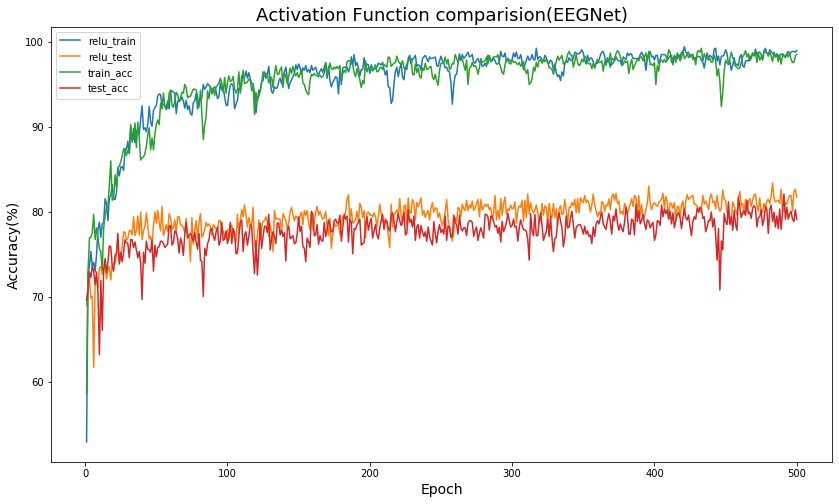

In [111]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))

plt.title("Activation Function comparision(EEGNet)", fontsize=18)
plt.ylabel("Accuracy(%)", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
x = np.arange(1, len(elu_train)+1)
# plt.plot(x, elu_train, label='elu_train')
# plt.plot(x, elu_test, label="elu_test")
plt.plot(x, relu_train, label="relu_train")
plt.plot(x, relu_test, label="relu_test")
# plt.plot(x, leakyrelu_train, label="leakyReLU_train")
# plt.plot(x, leakyrelu_test, label="leakyReLU_test")
plt.plot(x, train_acc, label="train_acc")
plt.plot(x, test_acc, label="test_acc")
plt.legend()
plt.show()

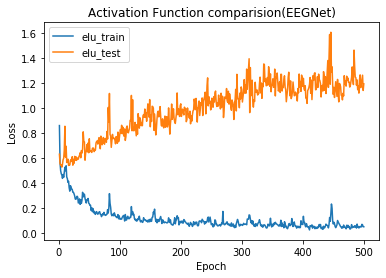

In [112]:
plt.figure()

plt.title("Activation Function comparision(EEGNet)")
plt.ylabel("Loss")
plt.xlabel("Epoch")
x = np.arange(1, len(train_loss)+1)
plt.plot(x, train_loss, label="elu_train")
plt.plot(x, test_loss, label="elu_test")
plt.legend()
plt.show()